# IMPORTS

In [1]:
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

In [2]:
import json
import os
import matplotlib.pyplot as plt
from AxonDeepSeg.testing.segmentation_scoring import *
import pickle

from time import time
#from ipywidgets.widgets import *

In [3]:
from scipy.misc import imread, imsave

# 1/ Define the parameters to use for the segmentation

In [4]:
# input data to build the training set
dataset_name = 'SEM_3c_512'
gps = 0.1

In [5]:
path_data = '../data/' + dataset_name + '/raw/'
path_testing = '../data/baseline_testing/SEM_data14/'
#path_testing = '../data/images_nyu_tem/'

# output path of training data path
path_training = '../data/' + dataset_name + '/training/'

im = imread(path_testing + 'image.png', mode='L', flatten=True)
imsave(path_testing + 'image.png', 255-im)

# 2/ Load the config file

Choose here the name of the model you want to load

In [6]:
#model_name = 'cv_3c_d4_c2_k3__0-1062' # TEM 3c 256
#model_name = 'cv_3c_d3_c2_k3__13-5185/'
#model_name = 'baseline_3c_balanced_nobn-1957' # SEM 3c 256 old
#model_name = 'cv_3c_d4_c2_k3__0-9097' # SEM 512
#model_name = 'cv_3c_d4_c2_k3__0-7678' # TEM 3c 512
#model_name = 'cv_3c_d4_c2_k3__0-8580' # mixed 3c 512
#model_name = 'cv_3c_d4_c2_k3__0-4698' # good working model
model_name = 'conv3_rate112-48_last256'

In [7]:
# optional input path of a model to initialize the training
#path_model_init = 'network_testing/test_2905'
path_model_init = None

# output path for trained U-Net
path_model = '../models/' + model_name

path_configfile = path_model + '/config_network.json'

if not os.path.exists(path_model):
    os.makedirs(path_model)

with open(path_configfile, 'r') as fd:
    config_network = json.loads(fd.read())
    
# OPTIONAL : specify the gpu one wants to use.
gpu_device = 'gpu:0' # or gpu_device = 'gpu:1' these are the only two possible targets for now.

# 3/ Apply the model to segment one image

#### Segmentation

In [8]:
from AxonDeepSeg.apply_model import axon_segmentation

In [9]:
pred, pred_proba = axon_segmentation([path_testing], ["image.png"], path_model, config_network, overlap_value=25, resampled_resolutions=gps, 
                                  prediction_proba_activate=True, write_mode=True, inference_batch_size=4, gpu_per=0.3, verbosity_level=10)

Loading acquisitions ...
Rescaling acquisitions to the target resolution ...
Graph construction ...
Beginning inference ...
processing patch 1 on 7
processing patch 2 on 7
processing patch 3 on 7
processing patch 4 on 7
processing patch 5 on 7
processing patch 6 on 7
processing patch 7 on 7
processing last patch


** TRANSFORMING PRED_PROBA INTO REAL PROBABILITIES **

In [10]:
pred_proba = pred_proba[0]

In [11]:
a = np.exp(pred_proba)
b = np.sum(a, axis=-1)
c = np.stack([np.divide(a[:,:,i],b) for i in range(3)], axis=-1)

Then we save the probabilities using a pickle file

path_saving = '../data/SEM_3classes_reduced/testing/pilou/'

with open(os.path.join(path_saving, 'pred_proba.pkl'), 'w') as handle:
    pickle.dump(c, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 4/ Visualisation of the segmentation

Import images

In [12]:
imorg = imread(path_testing + '/image.png', flatten=True)
imads = imread(path_testing + '/AxonDeepSeg.png', flatten=True)

Display original image

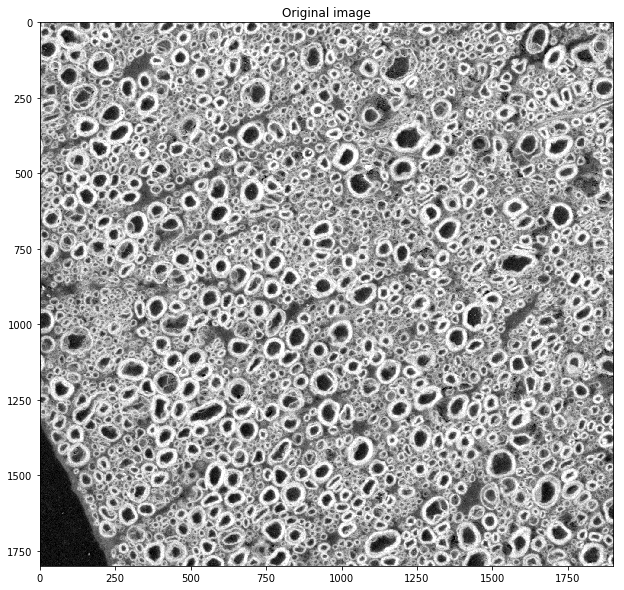

In [13]:
plt.figure(figsize=(13,10))
plt.title('Original image')
plt.imshow(imorg, cmap='gray')
plt.show();

Display segmentation and compare it with original image

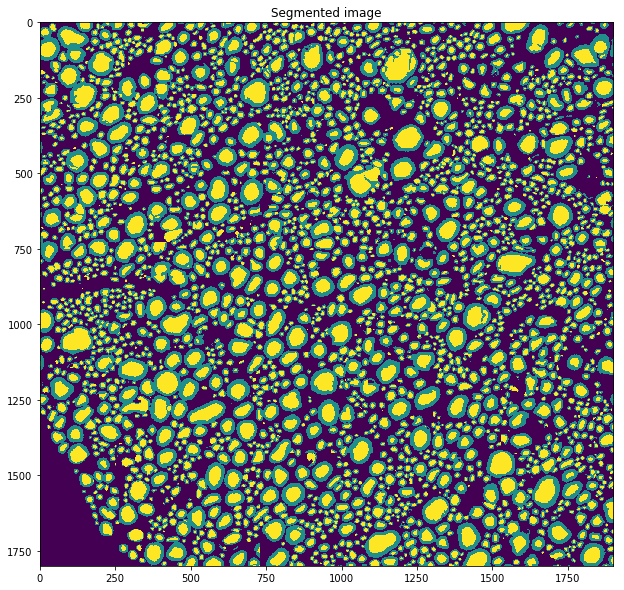

In [14]:
plt.figure(figsize=(13,10))
plt.title('Segmented image')
plt.imshow(imads)
plt.show();

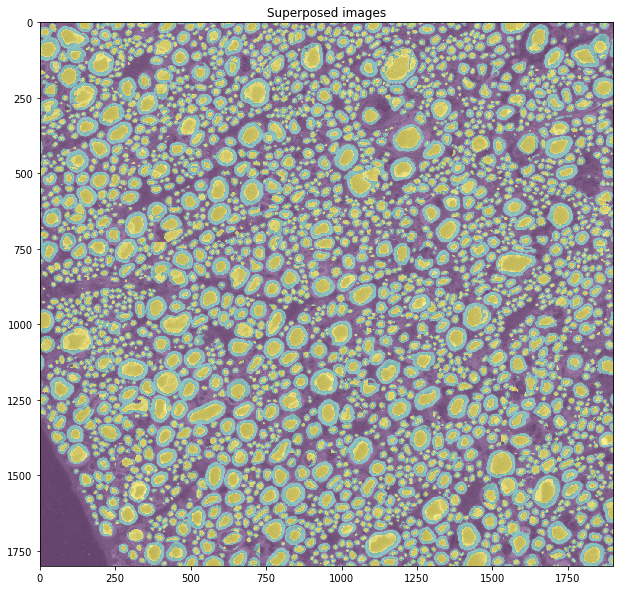

In [15]:
plt.figure(figsize=(13,10))
plt.title('Superposed images')
plt.imshow(imorg, cmap='gray', alpha=0.5)
plt.imshow(imads, cmap='viridis', alpha=0.5)

In [16]:
imorg.shape

(1801, 1901)

# 5/ Metrics analysis

We are now going to analyze each class dice. First we compute masks for each prediction and each ground truth

In [17]:
mask = imread(path_testing + '/mask.png', flatten=True)
pred = imread(path_testing + '/AxonDeepSeg.png', flatten=True)

In [18]:
pred.shape

(1801, 1901)

In [19]:
mask.shape

(1801, 1901)

Creating the mask necessary to compute the dice

In [20]:
gt_axon = 1.0*(mask > 200)
gt_myelin = 1.0*np.logical_and(mask >= 50, mask <= 200)
gt_bg = 1.0*(mask < 50)

per_axon=np.sum(gt_axon)/(np.shape(gt_axon)[0]*np.shape(gt_axon)[1])
per_myelin=np.sum(gt_myelin)/(np.shape(gt_axon)[0]*np.shape(gt_axon)[1])
per_bg=np.sum(gt_bg)/(np.shape(gt_axon)[0]*np.shape(gt_axon)[1])

pred_axon = 1.0*(pred > 200)
pred_myelin = 1.0*np.logical_and(pred >= 50, pred <= 200)
pred_bg = 1.0*(pred < 50)

Computation of the accuracy

In [21]:
from sklearn.metrics import accuracy_score

In [22]:
gt_discretized=np.zeros_like(gt_bg)+gt_myelin+2*gt_axon
pred_discretized=np.zeros_like(pred_bg)+pred_myelin+2*pred_axon

In [23]:
total_accuracy=accuracy_score(gt_discretized.ravel(),pred_discretized.ravel())

Affichage de chaque classe

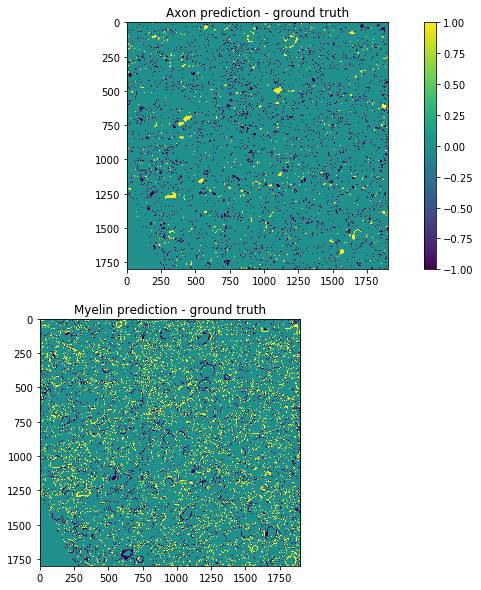

In [24]:
plt.figure(figsize=(13,10))
plt.subplot(2,1,1)
plt.imshow(pred_axon.astype(int) - gt_axon.astype(int))
plt.title('Axon prediction - ground truth')
plt.colorbar()
plt.subplot(2,1,2)
plt.imshow(pred_myelin.astype(int) - gt_myelin.astype(int))
plt.title('Myelin prediction - ground truth')
plt.show();

In [25]:
float(np.sum(pred_myelin.astype(int) - gt_myelin.astype(int)))/(imorg.shape[0]*imorg.shape[1])

0.03111252997852324

### Computing the dice for axon and myelin

In [26]:
dice_axon = pw_dice(pred_axon, gt_axon)
dice_myelin = pw_dice(pred_myelin, gt_myelin)
dice_bg = pw_dice(pred_bg, gt_bg)
total_dice = per_bg*dice_bg + per_myelin*dice_myelin + per_axon*dice_axon

print 'Dice for Axon : ' + str(dice_axon)
print 'Dice for myelin : ' + str(dice_myelin)
print 'Dice for Background : ' + str(dice_bg)
print 'Total dice : ' + str(total_dice)

Dice for Axon : 0.8442485813740571
Dice for myelin : 0.7763625826389252
Dice for Background : 0.8621199356666922
Total dice : 0.8303521098304314


Computing sensitivity, precision and diffusion

score_analysis(imorg, gt_axon, pred_axon)

Displaying the element-wise dice for the axon class

data_axon_dice = dice(imorg, gt_axon, pred_axon, min_area=4)

data_axon_dice['dice'].quantile([0.1, 0.5, 0.9, 0.95]).values

# 6/ Average Precision computation

In [27]:
ground_truth=np.zeros_like(c)
for i,elem in enumerate(np.unique(mask)):
    ground_truth[:,:,i]=1.0*(mask==elem)

First, we fuse the 2 spatial dimensions of the arrays

In [28]:
probability_map=np.reshape(c,(c.shape[0]*c.shape[1],c.shape[2]))
ground_truth=np.reshape(ground_truth,(ground_truth.shape[0]*ground_truth.shape[1],ground_truth.shape[2]))

In [29]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
n_classes=3
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(ground_truth[:, i],
                                                        probability_map[:, i])
    average_precision[i] = average_precision_score(ground_truth[:, i], probability_map[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(ground_truth.ravel(),
    probability_map.ravel())
average_precision["micro"] = average_precision_score(ground_truth, probability_map,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.92


In [30]:
import pickle

In [31]:
path_saving=os.path.join('../models/',model_name)

save_dict={'recall':recall,
           'precision':precision,
           'mAP':average_precision,
           'dice':{'axon':dice_axon,
                   'myelin':dice_myelin,
                   'bg':dice_bg,
                   'micro':total_dice},
           'total_acc':total_accuracy}
with open(os.path.join(path_saving, 'pixel_wise_statistics.pkl'), 'w') as handle:
    pickle.dump(save_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)